In [2]:
import os
import json
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")
sns.set()

# 1. Loading Data

In [5]:
def load_dpt(dept_list, year_file='2018'):
    df_list = []
    FOLDER = '/Users/thibaud/Documents/Data/DVF/data_per_dept'
    for dept in dept_list:
        try:
            print(' - Loading dept {}'.format(dept))
            path = '{}/processed_{}/dept_{}.csv'.format(FOLDER, year_file, dept)
            df = pd.read_csv(path, low_memory=False)
            df_list.append(df)
        except:
            print(' - {} was not found.'.format(dept))
    df = pd.concat(df_list)
    return df

# 2.Processing

In [6]:
def compute_prix_m2(df):
    #print('> Computing m2...')
    df['prix_m2'] = df['prix'].div(df['surface']).apply(np.round)
    df = df[df['prix_m2']<10000]

    return df

def display_shape(df, msg='Shape'):
    print(' - {} : {} '.format(msg, df.shape))
    return df

def select_price_range(df, min_=0, max_=1000000):
    df_1 = df[df['prix'] > min_]
    df_2 = df_1[df_1['prix'] < max_]
#     df_thib['prix_m2'].mean()
    return df_2


def select_type(df, type_='Appartement'):
    df_1 = df[df['type_local']== type_]
    df_1 = df_1.drop('type_local', axis=1)
    return df_1

def select_mutation(df, mutation='Vente'):
    df_1 = df[df['nature_mutation']== mutation]
    df_1 = df_1.drop('nature_mutation', axis=1)
    return df_1


def transform_date(df):
    df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
    return df

def select_cities(df, cities=None):
    if cities==None:
        return df
    
    df_list = []
    for city in cities:
        #print(' - Keeping city : {}'.format(city))
        df_list.append(df[df['ville']==city])
    df_final = pd.concat(df_list)
    return df_final

def calculate_adress(df, drop_col=False):
    df_1 = df.copy()
    df_1['adresse'] = df['no_voie'].apply(str) + ' ' +  df['type_de_voie'] + ' ' + df['voie']
    if drop_col:
        df_1 = df_1.drop(['no_voie', 'type_de_voie', 'voie'], axis=1)
    return df_1

# 3. Execution

Loading selected department

In [7]:
# Variables
dpt_list = ['33', '35', '44', '51']
rennes = ['RENNES', 'CESSON-SEVIGNE', 'CHANTEPIE']
nantes = ['NANTES', 'REZE', 'ST SEBASTIEN SUR LOIRE', 'ST-HERBLAIN']
bordeaux = ['BORDEAUX', 'TALENCE', 'PESSAC', 'MERIGNAC']
autres = ['REIMS'] #+ paris_list
selected_cities = rennes + nantes + bordeaux + autres
selected_col = ['date_mutation', 'prix_m2', 'surface',#'surface_terrain',
                'prix', 'ville', 'section',
                'nb_piece', 'dept', 'adresse']

prix_min = 80000
prix_max = 111000

In [8]:
dpt_list = ['92']
selected_cities = ['ISSY LES MOULINEAUX', 'ISSY-LES-MOULINEAUX'] #,'BOULOGNE BILLANCOURT' 'BOULOGNE-BILLANCOURT' 'BOURG LA REINE' 'BOURG-LA-REINE' ]
prix_min = 250000
prix_max = 400000

Help for selecting cities (only useful at start)

In [9]:
# City exploration
if True:
    communes = load_dpt(dpt_list)['ville'].unique()
    communes.sort()
    paris_list = [commune for commune in communes if 'PARIS ' in commune]
    print(communes)
    print([commune for commune in communes if commune.startswith('IS')])
    print([commune for commune in communes if 'CHANTE' in commune])

 - Loading dept 92
['ANTONY' 'ASNIERES-SUR-SEINE' 'BAGNEUX' 'BOIS COLOMBES' 'BOIS-COLOMBES'
 'BOULOGNE BILLANCOURT' 'BOULOGNE-BILLANCOURT' 'BOURG LA REINE'
 'BOURG-LA-REINE' 'CHATENAY-MALABRY' 'CHATILLON' 'CHAVILLE' 'CLAMART'
 'CLICHY' 'COLOMBES' 'COURBEVOIE' 'FONTENAY AUX ROSES'
 'FONTENAY-AUX-ROSES' 'GARCHES' 'GENNEVILLIERS' 'ISSY LES MOULINEAUX'
 'ISSY-LES-MOULINEAUX' 'LA GARENNE COLOMBES' 'LA GARENNE-COLOMBES'
 'LE PLESSIS ROBINSON' 'LE PLESSIS-ROBINSON' 'LEVALLOIS PERRET'
 'LEVALLOIS-PERRET' 'MALAKOFF' 'MARNES-LA-COQUETTE' 'MEUDON' 'MONTROUGE'
 'NANTERRE' 'NEUILLY SUR SEINE' 'NEUILLY-SUR-SEINE' 'PUTEAUX'
 'RUEIL MALMAISON' 'RUEIL-MALMAISON' 'SAINT CLOUD' 'SAINT-CLOUD' 'SCEAUX'
 'SEVRES' 'SURESNES' 'VANVES' 'VAUCRESSON' "VILLE-D'AVRAY"
 'VILLENEUVE LA GARENNE' 'VILLENEUVE-LA-GARENNE']
['ISSY LES MOULINEAUX', 'ISSY-LES-MOULINEAUX']
[]


Création du dataFrame

In [10]:
df = (load_dpt(dpt_list)
        .pipe(display_shape, 'Initial shape')
        .pipe(compute_prix_m2)
        .pipe(display_shape, 'Post m² shape')
        #.pipe(select_price_range, min_=prix_min, max_=prix_max)
        .pipe(display_shape, 'Post price shape')
        .pipe(select_cities, selected_cities)
        .pipe(select_type, 'Appartement')
        .pipe(select_mutation, 'Vente')
        .drop('code_voie', axis=1)
        .pipe(calculate_adress, drop_col = True)
        .pipe(display_shape, 'Final shape')
        .pipe(transform_date)
        .reset_index(drop=True)[selected_col]
        .set_index('date_mutation')
        .sort_index())

 - Loading dept 92
 - Initial shape : (45673, 20) 
 - Post m² shape : (17721, 21) 
 - Post price shape : (17721, 21) 
 - Final shape : (646, 16) 


Affichage des informations relatives au dataset

In [11]:
df[df.section.isin(['S', 'T'])].sort_values('prix').iloc[10:]

,prix_m2,surface,prix,ville,section,nb_piece,dept,adresse
date_mutation,,,,,,,,
2018-03-21,6175.0,28.0,172897,ISSY-LES-MOULINEAUX,S,1.0,92,102 BD GALLIENI
2018-01-22,5135.0,37.0,190000,ISSY-LES-MOULINEAUX,S,2.0,92,52 AV VICTOR CRESSON
2018-11-04,6061.0,33.0,200000,ISSY-LES-MOULINEAUX,S,2.0,92,17 RUE ROGER SALENGRO
2018-02-19,7000.0,30.0,210000,ISSY-LES-MOULINEAUX,S,2.0,92,21 RUE D ESTIENNE D ORVES
2018-10-04,5167.0,42.0,217000,ISSY-LES-MOULINEAUX,S,2.0,92,22 RUE D ESTIENNE D ORVES
2018-04-13,7520.0,29.0,218080,ISSY-LES-MOULINEAUX,T,2.0,92,14 RUE DANTON
2018-11-07,7897.0,29.0,229000,ISSY-LES-MOULINEAUX,S,2.0,92,26 RUE D ESTIENNE D ORVES
2018-02-15,6079.0,38.0,231000,ISSY-LES-MOULINEAUX,S,2.0,92,102 BD GALLIENI
2018-01-22,5714.0,42.0,240000,ISSY-LES-MOULINEAUX,S,2.0,92,20 RUE D ESTIENNE D ORVES


In [12]:
#np.random.randn(200)

In [13]:
def display_unique(df, col='Code postal'):    
    print(col)
    code_postaux = df[col].unique()
    code_postaux.sort()
    print(code_postaux,'\n')

print(df.shape)
#for col in ['Code departement', 'Commune', 'Code postal']:
#    df.pipe(display_unique, col)

(646, 8)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 646 entries, 2018-01-02 to 2018-12-28
Data columns (total 8 columns):
prix_m2     646 non-null float64
surface     646 non-null float64
prix        646 non-null int64
ville       646 non-null object
section     646 non-null object
nb_piece    646 non-null float64
dept        646 non-null int64
adresse     644 non-null object
dtypes: float64(3), int64(2), object(3)
memory usage: 45.4+ KB


# Exploration d'une ville

In [15]:
ville = 'ISSY-LES-MOULINEAUX'
df_ville = df[df['ville']==ville]
df_ville = df_ville[df_ville.prix < 500000]
print(ville)
print('{} ventes en 2018'.format(df_ville.shape[0]))
print('Prix moyen : {} €/m2'.format(np.round(df_ville['prix_m2'].mean(),2)))
print('Prix median : {} €/m2'.format(np.round(df_ville['prix_m2'].median(),2)))
print('Surface moyenne : {} m2'.format(np.round(df_ville['surface'].mean(),2)))
print('{} section cadastrales.'.format(df_ville['section'].nunique()))

ISSY-LES-MOULINEAUX
480 ventes en 2018
Prix moyen : 6595.64 €/m2
Prix median : 6794.5 €/m2
Surface moyenne : 43.66 m2
38 section cadastrales.


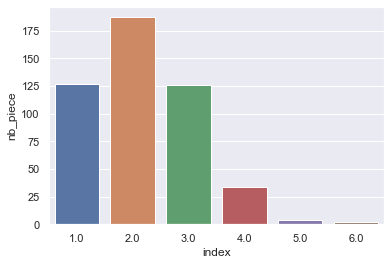

In [16]:
tmp = pd.DataFrame(df_ville['nb_piece'].value_counts().sort_index().reset_index())
sns.barplot(x="index", y="nb_piece", data=pd.DataFrame(tmp))

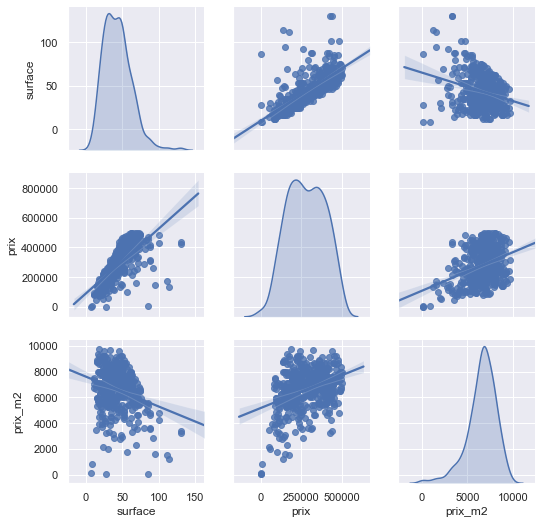

In [17]:
# Ajouter une couleur pour les bons prix_m2 vs normaux vs mauvais
sns.pairplot(df_ville, vars=["surface", "prix", "prix_m2"], diag_kind='kde', kind = 'reg')
#sns.pairplot(df_ville.pipe(select_price_range, min_=prix_min, max_=prix_max), vars=["surface", "prix", "prix_m2"], diag_kind='kde', kind = 'reg')

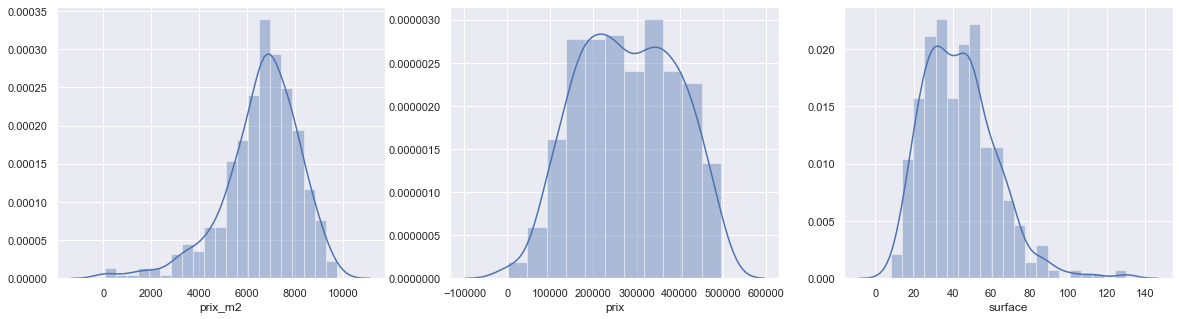

In [18]:
plt.figure(figsize=(20,5))
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 1)
sns.distplot(df_ville['prix_m2']) # mettre en regard prix m2, prix et surface
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 2)
sns.distplot(df_ville['prix']) # mettre en regard prix m2, prix et surface
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 3)
sns.distplot(df_ville['surface']) # mettre en regard prix m2, prix et surface

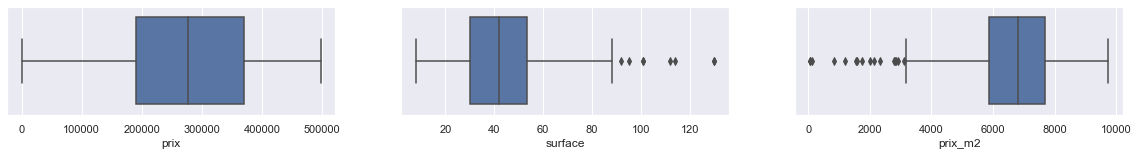

In [19]:
plt.figure(figsize=(20,2))
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 1)
sns.boxplot(df_ville['prix'])
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 2)
sns.boxplot(df_ville['surface'])
# répartitions des ventes par prix_m2
plt.subplot(1, 3, 3)
sns.boxplot(df_ville['prix_m2'])

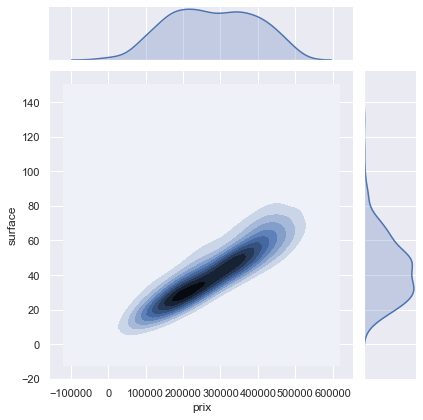

In [20]:
#plt.figure(figsize=(20,5))
sns.jointplot(x="prix", y="surface", data=df_ville,kind="kde") # kind = hex/reg/kde

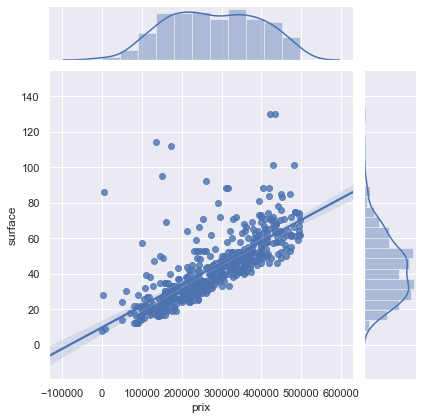

In [21]:
sns.jointplot(x="prix", y="surface", data=df_ville,kind="reg") # kind = hex/reg/kde

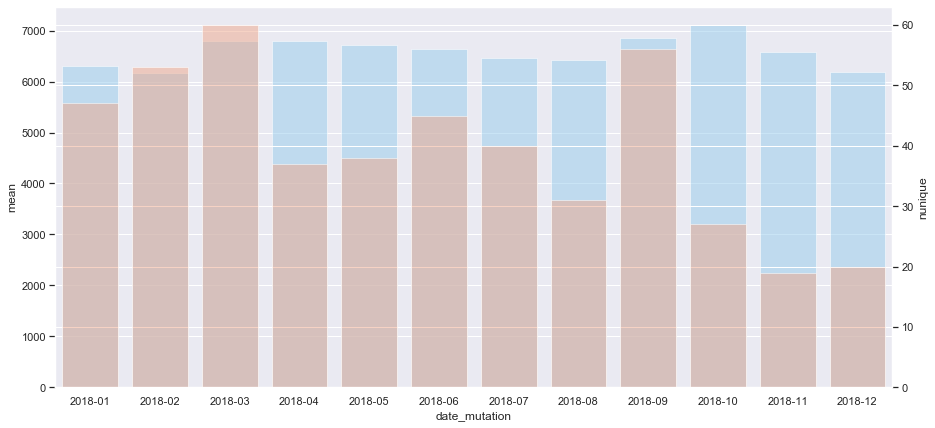

In [22]:
# Nombre de vente dans la ville par mois
plt.figure(figsize=(15,7))
tmp = df_ville.resample('M').agg({'prix_m2':['nunique', 'mean']}).apply(np.round).droplevel(level=0, axis=1).reset_index()
tmp['date_mutation'] = tmp['date_mutation'].apply(str).apply(lambda x:x[:7])
#plt.subplot(2, 1, 1)
sns.barplot(x='date_mutation', y='mean', data=tmp, color="lightskyblue", alpha=0.5)
#plt.subplot(2, 1, 2)
ax2 = plt.twinx()

sns.barplot(x='date_mutation', y='nunique', data=tmp,  color="lightsalmon",alpha=0.5, ax=ax2)


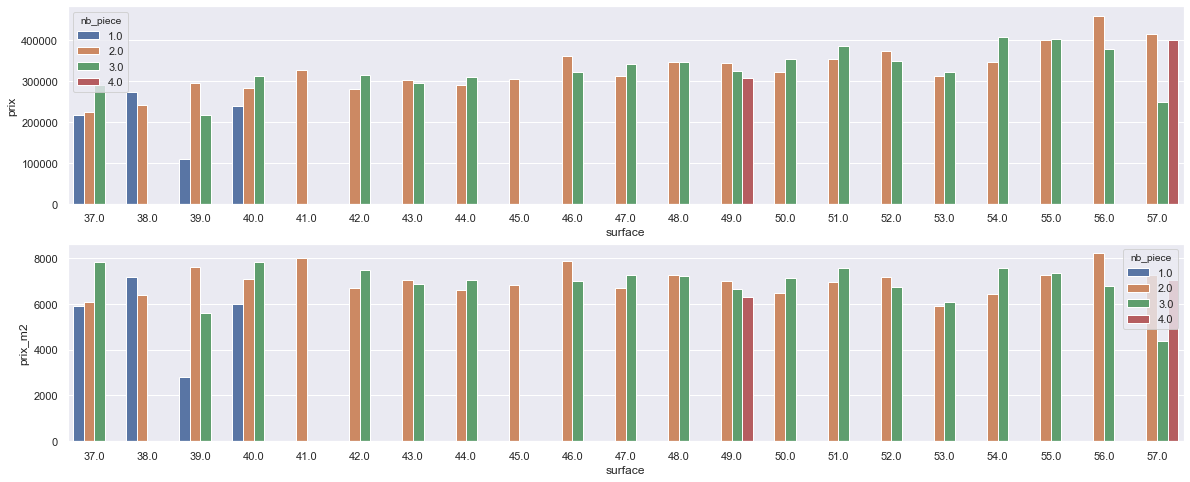

In [23]:
plt.figure(figsize=(20,8))
tmp = df_ville.groupby(['surface', 'nb_piece']).mean()[["prix_m2", 'prix']].apply(np.round).reset_index().iloc[45:90]
plt.subplot(2, 1, 1)
sns.barplot(x='surface', y='prix', data=tmp,  hue='nb_piece')
plt.subplot(2, 1, 2)
sns.barplot(x='surface', y='prix_m2', data=tmp,  hue='nb_piece')

## A. Inspection d'une section cadastrale

In [24]:
def get_position(adress):
    lat = adress
    lon = adress
    return  lat, lon

def get_section(lat, lon):
    closest_section = 'S' # CZ, DE, DH
    return closest_section

In [25]:
adress = '18 rue des champs'
lat, lon = get_position(adress)
section = get_section(lat, lon)
df_section = df_ville[df_ville.section ==section]

In [26]:
df_section.sort_values('surface')

,prix_m2,surface,prix,ville,section,nb_piece,dept,adresse
date_mutation,,,,,,,,
2018-01-31,8906.0,16.0,142500,ISSY-LES-MOULINEAUX,S,1.0,92,12 ALL DES CITEAUX
2018-09-27,8750.0,16.0,140000,ISSY-LES-MOULINEAUX,S,1.0,92,16 RUE ROGER SALENGRO
2018-04-19,7947.0,19.0,151000,ISSY-LES-MOULINEAUX,S,1.0,92,16 RUE ROGER SALENGRO
2018-01-16,6750.0,20.0,135000,ISSY-LES-MOULINEAUX,S,1.0,92,17 RUE DE LA FRATERNITE
2018-01-31,5481.0,26.0,142500,ISSY-LES-MOULINEAUX,S,1.0,92,12 ALL DES CITEAUX
2018-02-23,54.0,28.0,1500,ISSY-LES-MOULINEAUX,S,1.0,92,102 BD GALLIENI
2018-03-21,6175.0,28.0,172897,ISSY-LES-MOULINEAUX,S,1.0,92,102 BD GALLIENI
2018-11-07,7897.0,29.0,229000,ISSY-LES-MOULINEAUX,S,2.0,92,26 RUE D ESTIENNE D ORVES
2018-02-19,7000.0,30.0,210000,ISSY-LES-MOULINEAUX,S,2.0,92,21 RUE D ESTIENNE D ORVES


Inspection des sections par prix

In [27]:
df_section = df_ville.pipe(select_price_range, min_=80000, max_=111000).groupby('section').mean().apply(np.round).sort_values(by='prix_m2', ascending=False)


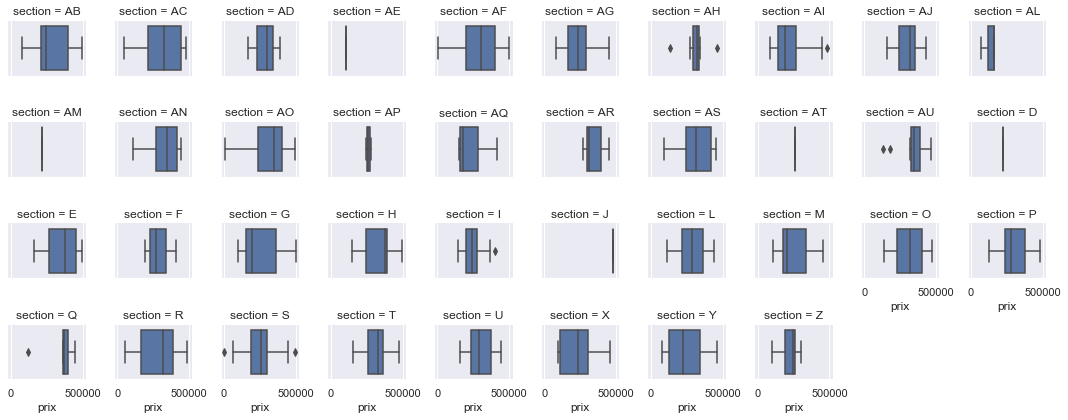

In [32]:
# Distributions dans les différentes sections de la ville
sns.factorplot(x='prix', data = df_ville.sort_values('section'), col='section', kind='box', col_wrap=10, height=1.5)

# Comparaison entre villes

In [40]:
df_comp = df_ville.pipe(select_price_range, min_=prix_min, max_=prix_max)

In [41]:
df_comp.head()

,prix_m2,surface,prix,ville,section,nb_piece,dept,adresse
date_mutation,,,,,,,,
2018-01-02,6792.0,53.0,360000,ISSY-LES-MOULINEAUX,O,3.0,92,109 AV DE VERDUN
2018-01-06,7236.0,55.0,398000,ISSY-LES-MOULINEAUX,AS,3.0,92,17 RUE L ABBE GREGOIRE
2018-01-06,8128.0,47.0,382000,ISSY-LES-MOULINEAUX,H,2.0,92,176 QUAI BATAILLE DE STALINGRAD
2018-01-08,7887.0,46.0,362800,ISSY-LES-MOULINEAUX,AO,2.0,92,16 PROM DU VERGER
2018-01-08,7000.0,53.0,371000,ISSY-LES-MOULINEAUX,G,2.0,92,4 CHE DE BRETAGNE


In [42]:
df_agg = (df
           .groupby('ville')
           .agg({'prix_m2':['nunique', 'mean'],
                 'surface':'mean'})
           .apply(np.round)  
              )
df_agg
#json.loads(df_agg['prix_m2', 'mean'].to_json())

prix_m2         surface
                    nunique    mean    mean
ville                                      
ISSY-LES-MOULINEAUX     563  6935.0    54.0

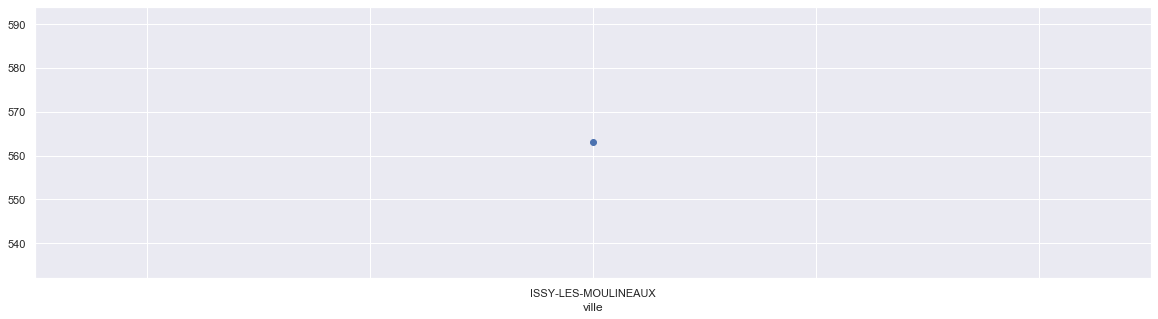

In [43]:
plt.figure(figsize=(20,5))
df_agg['prix_m2', 'nunique'].plot(linewidth=0.1, marker = 'o')


In [37]:
# sns.pairplot(data=df_city[df_city['Commune']=='TALENCE'],
#         vars=["Valeur fonciere", "Surface reelle bati", 'prix_m2'],
#         kind='scatter',
#         hue='Section',
#         palette='RdBu',
#         diag_kws={'alpha':.5})

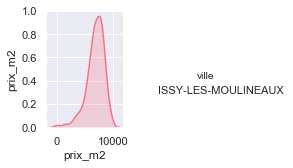

In [45]:
#sns.distplot(df_city[df_city['Code departement']==33]['prix_m2'])
sns.pairplot(df[df['dept']==92][['prix_m2', 'ville']], hue='ville', palette="husl")

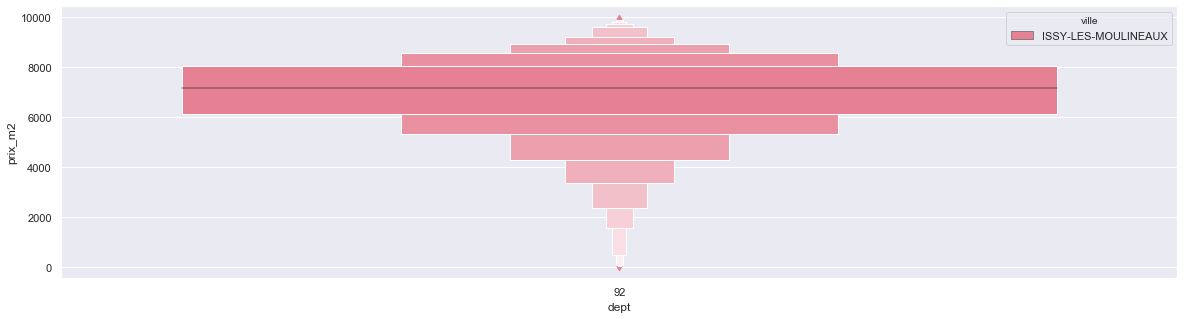

In [46]:
plt.figure(figsize=(20,5))
sns.lvplot(data=df[df['dept'] >70],
         x='dept',
         y='prix_m2',
         hue='ville',
         palette='husl'
        )

#plt.legend(loc=0)

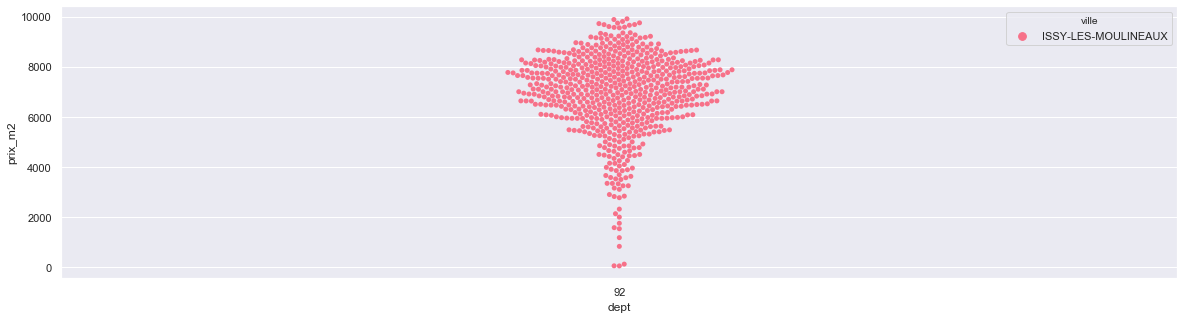

In [47]:
plt.figure(figsize=(20,5))
sns.swarmplot(data=df,
         x='dept',
         y='prix_m2',
         hue='ville',
         palette='husl')

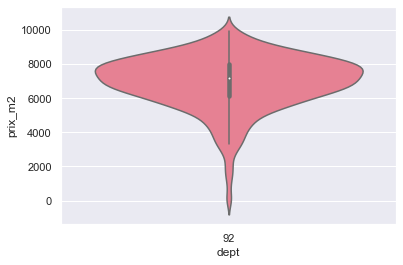

In [48]:
# Create a violinplot with the husl palette
sns.violinplot(data=df,
         x='dept',
         y='prix_m2',
         palette='husl')

plt.show()

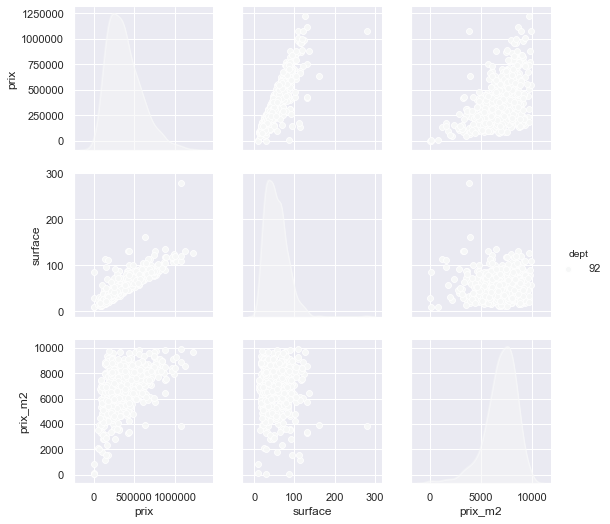

In [52]:
sns.pairplot(data=df,
        vars=["prix", "surface", 'prix_m2'],
        kind='scatter',
        hue='dept',
        palette='RdBu',
        diag_kws={'alpha':.5})

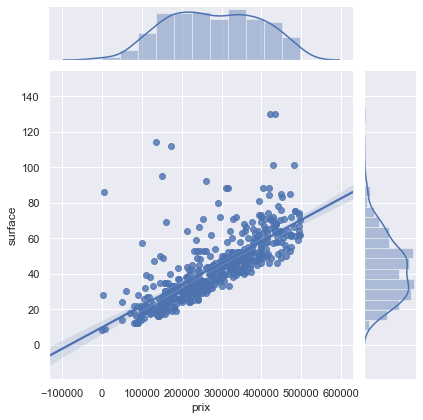

In [56]:
sns.jointplot(x="prix", y="surface", data=df_ville[df_ville['dept']==92],kind="reg",)
#sns.relplot(x="Valeur fonciere", y="Surface reelle bati", hue="Commune", data=df_city[df_city['Code departement']==33])

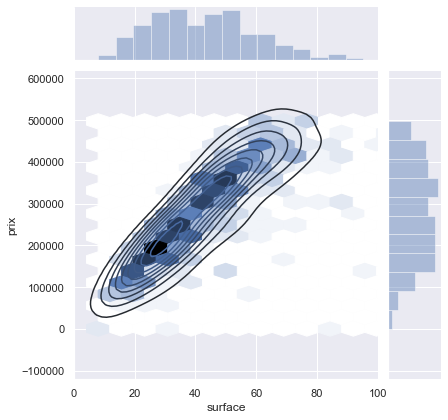

In [57]:
sns.jointplot(data=df_ville, y='prix', x ='surface', xlim=(0,100), kind='hex').plot_joint(sns.kdeplot)

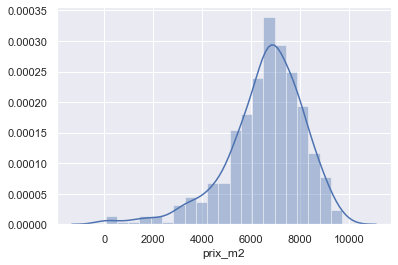

In [58]:
sns.distplot(df_ville['prix_m2'])

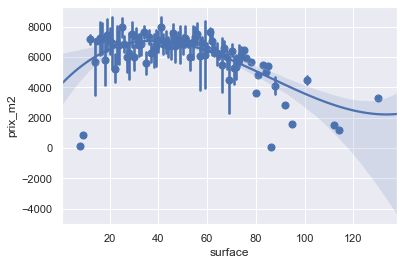

In [59]:
# Make the regression
sns.regplot(data=df_ville,
         x="surface",
         y="prix_m2", order=3, x_estimator=np.mean)

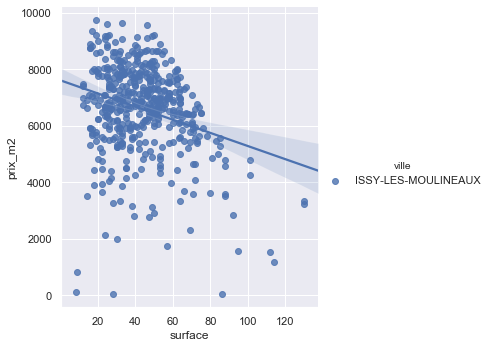

In [60]:
# Create a regression plot using hue
sns.lmplot(data=df_ville,
           x="surface",
           y="prix_m2", hue='ville')

# Show the results
plt.show()

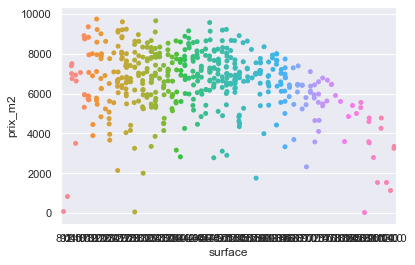

In [61]:
# Create the stripplot
sns.stripplot(data=df_ville,
           x="surface",
           y="prix_m2",
         jitter=True)

plt.show()

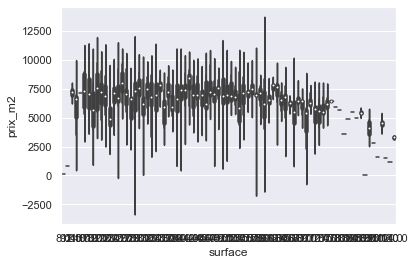

In [62]:
# Create a violinplot with the husl palette
sns.violinplot(data=df_ville,
         x="surface",
         y='prix_m2',
         palette='husl')

plt.show()

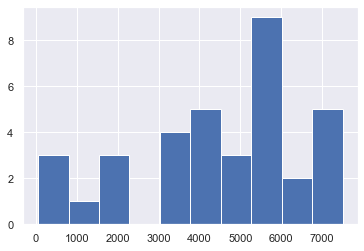

In [63]:
df_ville[df_ville['prix'] < 110000].prix_m2.hist(bins=10)

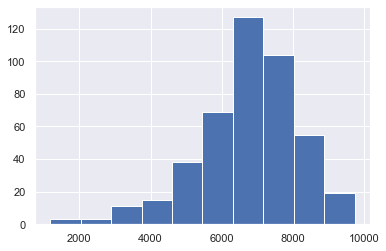

In [64]:
df_ville[df_ville['prix'] > 110000].prix_m2.hist(bins=10)

In [65]:
df_ville.columns

Index(['prix_m2', 'surface', 'prix', 'ville', 'section', 'nb_piece', 'dept',
       'adresse'],
      dtype='object')

In [66]:
df_thib = df_ville[df_ville['prix'] < 110000]
df_thib = df_thib[df_thib['prix'] > 90000]
df_thib['prix_m2'].mean()

5177.0

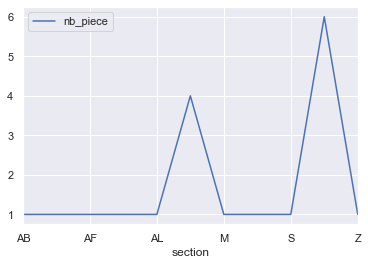

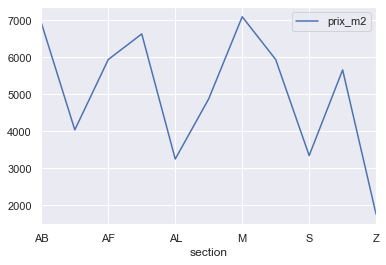

In [73]:
df_thib[df_thib.prix_m2 <10000 ].groupby(['ville', 'section']).agg({'prix_m2':'mean', 'nb_piece':'count'}).loc['ISSY-LES-MOULINEAUX'][['nb_piece']].plot()
df_thib[df_thib.prix_m2 <10000 ].groupby(['ville', 'section']).agg({'prix_m2':'mean', 'nb_piece':'count'}).loc['ISSY-LES-MOULINEAUX'][['prix_m2']].plot()

In [74]:
df_thib.head()

,prix_m2,surface,prix,ville,section,nb_piece,dept,adresse
date_mutation,,,,,,,,
2018-01-10,4833.0,20.0,96663,ISSY-LES-MOULINEAUX,G,1.0,92,4 PL JACQUES MADAULE
2018-01-15,3344.0,32.0,107000,ISSY-LES-MOULINEAUX,S,2.0,92,48 AV VICTOR CRESSON
2018-01-18,7093.0,15.0,106400,ISSY-LES-MOULINEAUX,M,1.0,92,32 RUE JEAN PIERRE TIMBAUD
2018-01-26,4038.0,26.0,105000,ISSY-LES-MOULINEAUX,AE,1.0,92,4 RUE DE VANVES
2018-02-06,5938.0,16.0,95000,ISSY-LES-MOULINEAUX,AF,1.0,92,6 RUE EDOUARD BRANLY


In [75]:
df_thib['section']

date_mutation
2018-01-10     G
2018-01-15     S
2018-01-18     M
2018-01-26    AE
2018-02-06    AF
2018-02-15     X
2018-02-21     G
2018-04-05     Z
2018-05-04     G
2018-05-04     G
2018-05-31    AL
2018-06-13     R
2018-07-17     X
2018-07-24     X
2018-09-01    AG
2018-09-14     X
2018-09-19    AB
2018-09-28     X
2018-09-28     X
Name: section, dtype: object